<a href="https://colab.research.google.com/github/kramerkraus/2155-CP3-mkraus/blob/main/diffusionmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [213]:
#make it so i can access files in the folder 2155-CP3-mkraus
import sys
sys.path.append('/content/2155-CP3-mkraus/')
from utils import *
from evaluate import *

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [214]:
# Load dataset from CSV files
data_dir = '/content/2155-CP3-mkraus/dataset'
splits = load_dataset_splits(data_dir)

# Get feature names from the CSV file
feature_names = pd.read_csv(os.path.join(data_dir, 'train_original.csv')).columns.tolist()
print(f"\n✓ Features loaded: {len(feature_names)} features")
print(f"Feature names: {feature_names[:5]}...{feature_names[-5:]}")  # Show first and last 5

Loading dataset splits from: /content/2155-CP3-mkraus/dataset

Loading train split...
  ✓ train_original.csv: (2998, 37)
  ✓ train_imputed.csv: (2998, 37)
  ✓ train_missing_mask.csv: (2998, 37)

Loading val split...
  ✓ val_original.csv: (375, 37)
  ✓ val_imputed.csv: (375, 37)
  ✓ val_missing_mask.csv: (375, 37)

Loading test split...
  ✓ test_original.csv: (375, 37)
  ✓ test_imputed.csv: (375, 37)
  ✓ test_missing_mask.csv: (375, 37)

Loading test2 split...
  ✓ test2_imputed.csv: (417, 37)
  ✓ test2_missing_mask.csv: (417, 37)

✓ Features loaded: 37 features
Feature names: ['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5']...['Feature 33', 'Feature 34', 'Feature 35', 'Feature 36', 'Feature 37']


In [215]:
# Data exploration and analysis
print("\n" + "="*70)
print("DATASET ANALYSIS")
print("="*70)

# Extract data for easier access
X_train = splits['train']['imputed']
mask_train = splits['train']['missing_mask']
X_train_original = splits['train']['original']

X_val = splits['val']['imputed']
mask_val = splits['val']['missing_mask']
X_val_original = splits['val']['original']

X_test = splits['test']['imputed']
mask_test = splits['test']['missing_mask']
X_test_original = splits['test']['original']

# Test2 data (no original available for evaluation)
X_test2 = splits['test2']['imputed']
mask_test2 = splits['test2']['missing_mask']

print(f"\nData shapes:")
print(f"  - Training: {X_train.shape}")
print(f"  - Validation: {X_val.shape}")
print(f"  - Test: {X_test.shape}")
print(f"  - Test2: {X_test2.shape} (evaluation set - no ground truth)")


DATASET ANALYSIS

Data shapes:
  - Training: (2998, 37)
  - Validation: (375, 37)
  - Test: (375, 37)
  - Test2: (417, 37) (evaluation set - no ground truth)


In [216]:
# Data Preprocessing (Handle Missing Values)

print("\n" + "="*70)
print("DATA PREPROCESSING")
print("="*70)

# Handle missing values properly
print("Processing missing values and preparing data...")
print("Mask convention: True=missing, False=observed (in original masks)")

print(f"\n✓ Data preprocessing completed successfully")
print(f"  - Training data range: [{X_train_original[~mask_train].min():.3f}, {X_train_original[~mask_train].max():.3f}]")
print(f"  - Validation data range: [{X_val_original[~mask_val].min():.3f}, {X_val_original[~mask_val].max():.3f}]")
print(f"  - Test data range: [{X_test_original[~mask_test].min():.3f}, {X_test_original[~mask_test].max():.3f}]")

# Create data loaders
batch_size = 64
print(f"\nCreating data loaders with batch size: {batch_size}")

train_dataset = TensorDataset(torch.FloatTensor(X_train_original), torch.FloatTensor((~mask_train).astype(float)))
val_dataset = TensorDataset(torch.FloatTensor(X_val_original), torch.FloatTensor((~mask_val).astype(float)))
test_dataset = TensorDataset(torch.FloatTensor(X_test_original), torch.FloatTensor((~mask_test).astype(float)))
test2_dataset = TensorDataset(torch.FloatTensor(X_test2), torch.FloatTensor((~mask_test2).astype(float)))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test2_loader = DataLoader(test2_dataset, batch_size=batch_size, shuffle=False)

# Preview a batch
sample_batch_data, sample_batch_mask = next(iter(train_loader))
print(f"\nSample batch shape: {sample_batch_data.shape}")
print(f"Sample batch mask shape: {sample_batch_mask.shape}")
print(f"Sample batch missing percentage: {(sample_batch_mask == 0).float().mean().item()*100:.1f}%")  # 0 = missing in model tensors



DATA PREPROCESSING
Processing missing values and preparing data...
Mask convention: True=missing, False=observed (in original masks)

✓ Data preprocessing completed successfully
  - Training data range: [0.000, 1.000]
  - Validation data range: [0.000, 1.000]
  - Test data range: [0.000, 1.000]

Creating data loaders with batch size: 64

Sample batch shape: torch.Size([64, 37])
Sample batch mask shape: torch.Size([64, 37])
Sample batch missing percentage: 20.1%


In [217]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


# --------------------------------------------------
# 1. Small MLP backbone (denoiser)
# --------------------------------------------------

class MLPDenoiser(nn.Module):
    def __init__(self, input_dim=37, hidden=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + 1 + input_dim, hidden), # x + t + mask
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, input_dim),
        )

    def forward(self, x_t, t, mask):
        """
        x_t: noised data
        t: time step (batch, 1)
        mask: binary mask (1 = observed, 0 = missing)
        """
        t = t / 1000.0       # normalize time
        inp = torch.cat([x_t, t, mask], dim=1)
        return self.net(inp)


# --------------------------------------------------
# 2. Diffusion core (betas, schedules, noise)
# --------------------------------------------------

def make_beta_schedule(T=1000, start=1e-4, end=0.02):
    return torch.linspace(start, end, T)


class Diffusion(nn.Module):
    def __init__(self, input_dim, timesteps=1000):
        super().__init__()
        self.T = timesteps
        betas = make_beta_schedule(timesteps)
        alphas = 1.0 - betas
        alphas_cum = torch.cumprod(alphas, dim=0)

        self.register_buffer("betas", betas)
        self.register_buffer("alphas", alphas)
        self.register_buffer("alphas_cum", alphas_cum)

        self.model = MLPDenoiser(input_dim=input_dim)

    # -------------------------
    # q(x_t | x_0)
    # -------------------------
    def q_sample(self, x0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x0)
        a_bar = self.alphas_cum[t].unsqueeze(1)
        return torch.sqrt(a_bar) * x0 + torch.sqrt(1 - a_bar) * noise, noise

    # -------------------------
    # Training step
    # -------------------------
    def forward(self, x0, mask):
        """
        x0 : clean data (batch, D)
        mask : 1 = observed, 0 = missing
        """
        B = x0.shape[0]
        device = x0.device

        # Random time t for each sample
        t = torch.randint(0, self.T, (B,), device=device)

        # Noise forward
        xt, noise = self.q_sample(x0, t, noise=None)

        # Condition on observed values
        xt = xt * (1 - mask) + x0 * mask

        # Predict noise
        noise_pred = self.model(xt, t.unsqueeze(1).float(), mask)

        # Loss only on missing entries
        loss = ((noise_pred - noise) ** 2 * (1 - mask)).mean()
        return loss

    # -------------------------
    # Sampling / imputation
    # -------------------------
    @torch.no_grad()
    def sample(self, x_obs, mask, guidance_scale=2.0):
      """x_obs has missing entries set to anything (will overwrite them).
      guidance_scale: w in cfg (>=1). w=1.0 -> no guidance, w>1.0 -> stronger conditioning.
      """

      x = torch.randn_like(x_obs)

      # Define the target categories for Feature 26
      feature_26_idx = 25 # Assuming 'Feature 26' is at index 25 (0-indexed)
      allowed_categories = torch.tensor([0.0, 0.5, 1.0], device=x.device, dtype=torch.float32)

      feature_25_idx = 24

      for t in reversed(range(self.T)):
          bt = self.betas[t]
          at = self.alphas[t]
          a_bar = self.alphas_cum[t]

          # ----- prepare two inputs: uncond and cond -----
          # For conditioned input, always respect observed values
          x_cond = x * (1 - mask) + x_obs * mask

          # For unconditioned input, do not inject observed values (i.e., no overwrite)
          x_uncond = x  # same x but without overwritten observed entries

          # t tensor
          t_tensor = torch.full((x.shape[0], 1), t, device=x.device).float()

          # Predict noise for uncond and cond
          noise_uncond = self.model(x_uncond, t_tensor, torch.zeros_like(mask))
          noise_cond = self.model(x_cond, t_tensor, mask)

          # Combine with guidance
          noise_pred = noise_uncond + guidance_scale * (noise_cond - noise_uncond)

          # DDPM update step (use combined noise_pred)
          coef1 = 1 / torch.sqrt(at)
          coef2 = (1 - at) / torch.sqrt(1 - a_bar)

          x = coef1 * (x - coef2 * noise_pred)

          if t > 0:
              x += torch.sqrt(bt) * torch.randn_like(x)

          # After update, ensure we keep observed values exactly (optional safety)
          x = x * (1 - mask) + x_obs * mask

          # --- Guidance for Feature 26 ---
          # Find samples where Feature 26 was originally missing
          missing_for_f26 = (mask[:, feature_26_idx] == 0)
          if missing_for_f26.any():
              # Get the current imputed values for Feature 26 for these samples
              values_to_constrain = x[missing_for_f26, feature_26_idx]

              # Calculate absolute differences to each allowed category
              diffs = torch.abs(values_to_constrain.unsqueeze(1) - allowed_categories)

              # Find the index of the closest allowed category
              closest_category_indices = torch.argmin(diffs, dim=1)

              # Snap the imputed values to the closest allowed category
              x[missing_for_f26, feature_26_idx] = allowed_categories[closest_category_indices]



           # --- Guidance for Feature 25 ---
          # Find samples where Feature 26 was originally missing
          missing_for_f25 = (mask[:, feature_25_idx] == 0)
          if missing_for_f25.any():
              # Get the current imputed values for Feature 25 for these samples
              values_to_constrain = x[missing_for_f25, feature_25_idx]

              # Calculate absolute differences to each allowed category
              diffs = torch.abs(values_to_constrain.unsqueeze(1) - allowed_categories)

              # Find the index of the closest allowed category
              closest_category_indices = torch.argmin(diffs, dim=1)

              # Snap the imputed values to the closest allowed category
              x[missing_for_f25, feature_25_idx] = allowed_categories[closest_category_indices]




      # xmin = x.min(dim=0, keepdim=True).values
      # xmax = x.max(dim=0, keepdim=True).values

      # x_scaled = (x - xmin) / (xmax - xmin + 1e-12)


      return x # x_scaled

In [218]:
model = Diffusion(input_dim=37, timesteps=10).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [219]:
for epoch in range(200):
    for batch, mask in train_loader:
        batch = batch.to(device)
        mask = mask.to(device)

        loss = model(batch, mask)

        opt.zero_grad()
        loss.backward()
        opt.step()

    print(f"epoch {epoch} | loss {loss.item():.4f}")

epoch 0 | loss 0.2061
epoch 1 | loss 0.1851
epoch 2 | loss 0.1918
epoch 3 | loss 0.1671
epoch 4 | loss 0.1982
epoch 5 | loss 0.1795
epoch 6 | loss 0.1447
epoch 7 | loss 0.1633
epoch 8 | loss 0.1644
epoch 9 | loss 0.1719
epoch 10 | loss 0.1540
epoch 11 | loss 0.1368
epoch 12 | loss 0.1529
epoch 13 | loss 0.1236
epoch 14 | loss 0.1426
epoch 15 | loss 0.1378
epoch 16 | loss 0.1516
epoch 17 | loss 0.1334
epoch 18 | loss 0.1207
epoch 19 | loss 0.1378
epoch 20 | loss 0.1215
epoch 21 | loss 0.1319
epoch 22 | loss 0.1601
epoch 23 | loss 0.1406
epoch 24 | loss 0.1418
epoch 25 | loss 0.1319
epoch 26 | loss 0.1527
epoch 27 | loss 0.1499
epoch 28 | loss 0.1358
epoch 29 | loss 0.1329
epoch 30 | loss 0.1548
epoch 31 | loss 0.1257
epoch 32 | loss 0.1263
epoch 33 | loss 0.1166
epoch 34 | loss 0.1184
epoch 35 | loss 0.1231
epoch 36 | loss 0.1128
epoch 37 | loss 0.1525
epoch 38 | loss 0.1353
epoch 39 | loss 0.1355
epoch 40 | loss 0.1634
epoch 41 | loss 0.1460
epoch 42 | loss 0.1229
epoch 43 | loss 0.135

In [220]:
# x_incomplete = X_test_imputed[i]      # has -1 replaced by something
# mask = (X_test_missing_mask[i] == 0)  # convert your mask to 1/0 observed/missing

# x_incomplete = torch.tensor(x_incomplete).float().to(device)
# mask = torch.tensor(mask).float().to(device)

# samples = []

# for _ in range(20):
#     x_gen = model.sample(x_incomplete.unsqueeze(0), mask.unsqueeze(0))
#     samples.append(x_gen.cpu().numpy())

# samples = np.array(samples)   # (20, 1, 37)

In [221]:
def evaluate_imputation(model, data_loader, device):
    """Evaluate imputation performance."""
    model.eval()

    all_imputations = []
    all_originals = []
    all_masks = []

    with torch.no_grad():
        for batch_data_original, batch_mask_original in data_loader:
            batch_data_original = batch_data_original.to(device)
            batch_mask_original = batch_mask_original.to(device)

            # Use the model's sampling method for imputation
            imputed_data = model.sample(batch_data_original, batch_mask_original)

            all_imputations.append(imputed_data.cpu().numpy())
            all_originals.append(batch_data_original.cpu().numpy())
            all_masks.append(batch_mask_original.cpu().numpy())

    # Concatenate all results
    imputations = np.vstack(all_imputations)
    originals = np.vstack(all_originals)
    masks = np.vstack(all_masks)

    return imputations, originals, masks

In [222]:
print("\n" + "="*70)
print("MODEL EVALUATION")
print("="*70)

# Evaluate on test set
print("Evaluating model on test set...")
test_imputations, test_originals, test_masks = evaluate_imputation(
    model, test_loader, device
)

print(f"✓ Test set evaluation completed")
print(f"  - Test samples: {test_imputations.shape[0]}")
print(f"  - Features: {test_imputations.shape[1]}")

test_imputations_denorm = test_imputations  # Already in original scale
test_original_denorm = X_test_original  # Already in original scale

# Calculate comprehensive metrics
print("\nCalculating comprehensive metrics...")
feature_metrics = {}

# Create masks for missing values (where we need to evaluate imputation)
missing_mask = (test_masks == 0)  # True where values were missing (0 in model tensors = missing)

for i, feature_name in enumerate(feature_names):
    if missing_mask[:, i].sum() > 0:  # Only evaluate features with missing values
        # Get imputed and ground truth values for missing positions only
        imputed_missing = test_imputations_denorm[missing_mask[:, i], i]
        ground_truth_missing = test_original_denorm[missing_mask[:, i], i]

        # Calculate metrics
        mse = mean_squared_error(ground_truth_missing, imputed_missing)
        mae = mean_absolute_error(ground_truth_missing, imputed_missing)

        # Correlation
        try:
            correlation = np.corrcoef(ground_truth_missing, imputed_missing)[0, 1]
        except:
            correlation = np.nan

        # Mean difference and Jensen-Shannon divergence
        mean_diff, js_div = calculate_jsd_and_mean_diff(
            imputed_missing, ground_truth_missing, feature_name
        )

        feature_metrics[feature_name] = {
            'n_missing': missing_mask[:, i].sum(),
            'mse': mse,
            'mae': mae,
            'correlation': correlation,
            'mean_difference': mean_diff,
            'js_divergence': js_div,
        }

print(f"✓ Metrics calculated for {len(feature_metrics)} features with missing values")

# Display metrics for last 4 features (as requested)
print(f"\n" + "="*100)
print("METRICS FOR LAST 4 FEATURES")
print("="*100)
print(f"{'Feature':<15} {'N_Miss':<8} {'MSE':<10} {'MAE':<10} {'Corr':<8} {'Mean_Diff':<10} {'JS_Div':<8}")
print("-" * 100)

last_4_features = list(feature_metrics.keys())[-4:] if len(feature_metrics) >= 4 else list(feature_metrics.keys())

for feature in last_4_features:
    metrics = feature_metrics[feature]
    print(f"{feature:<15} {metrics['n_missing']:<8} {metrics['mse']:<10.4f} {metrics['mae']:<10.4f} "
          f"{metrics['correlation']:<8.3f} {metrics['mean_difference']:<10.4f} {metrics['js_divergence']:<8.4f} ")

# Summary statistics
all_mse = [m['mse'] for m in feature_metrics.values() if not np.isnan(m['mse'])]
all_mae = [m['mae'] for m in feature_metrics.values() if not np.isnan(m['mae'])]
all_corr = [m['correlation'] for m in feature_metrics.values() if not np.isnan(m['correlation'])]
all_mean_diff = [m['mean_difference'] for m in feature_metrics.values() if not np.isnan(m['mean_difference'])]
all_js_div = [m['js_divergence'] for m in feature_metrics.values() if not np.isnan(m['js_divergence'])]

print(f"\nSummary Statistics Across All Features:")
print(f"  - Average MSE: {np.mean(all_mse):.4f} ± {np.std(all_mse):.4f}")
print(f"  - Average MAE: {np.mean(all_mae):.4f} ± {np.std(all_mae):.4f}")
print(f"  - Average Correlation: {np.mean(all_corr):.3f} ± {np.std(all_corr):.3f}")
print(f"  - Average Mean Difference: {np.mean(all_mean_diff):.4f} ± {np.std(all_mean_diff):.4f}")
print(f"  - Average JS Divergence: {np.mean(all_js_div):.4f} ± {np.std(all_js_div):.4f}")


MODEL EVALUATION
Evaluating model on test set...
✓ Test set evaluation completed
  - Test samples: 375
  - Features: 37

Calculating comprehensive metrics...
✓ Metrics calculated for 37 features with missing values

METRICS FOR LAST 4 FEATURES
Feature         N_Miss   MSE        MAE        Corr     Mean_Diff  JS_Div  
----------------------------------------------------------------------------------------------------
Feature 34      75       0.0418     0.1609     0.348    0.0698     0.4837   
Feature 35      75       0.1705     0.3257     0.201    0.1395     0.5078   
Feature 36      75       0.1029     0.2588     0.267    0.1460     0.5295   
Feature 37      75       0.1674     0.3027     0.397    0.0741     0.4249   

Summary Statistics Across All Features:
  - Average MSE: 0.2278 ± 0.1111
  - Average MAE: 0.3668 ± 0.1022
  - Average Correlation: 0.166 ± 0.151
  - Average Mean Difference: 0.1147 ± 0.0940
  - Average JS Divergence: 0.4347 ± 0.1081


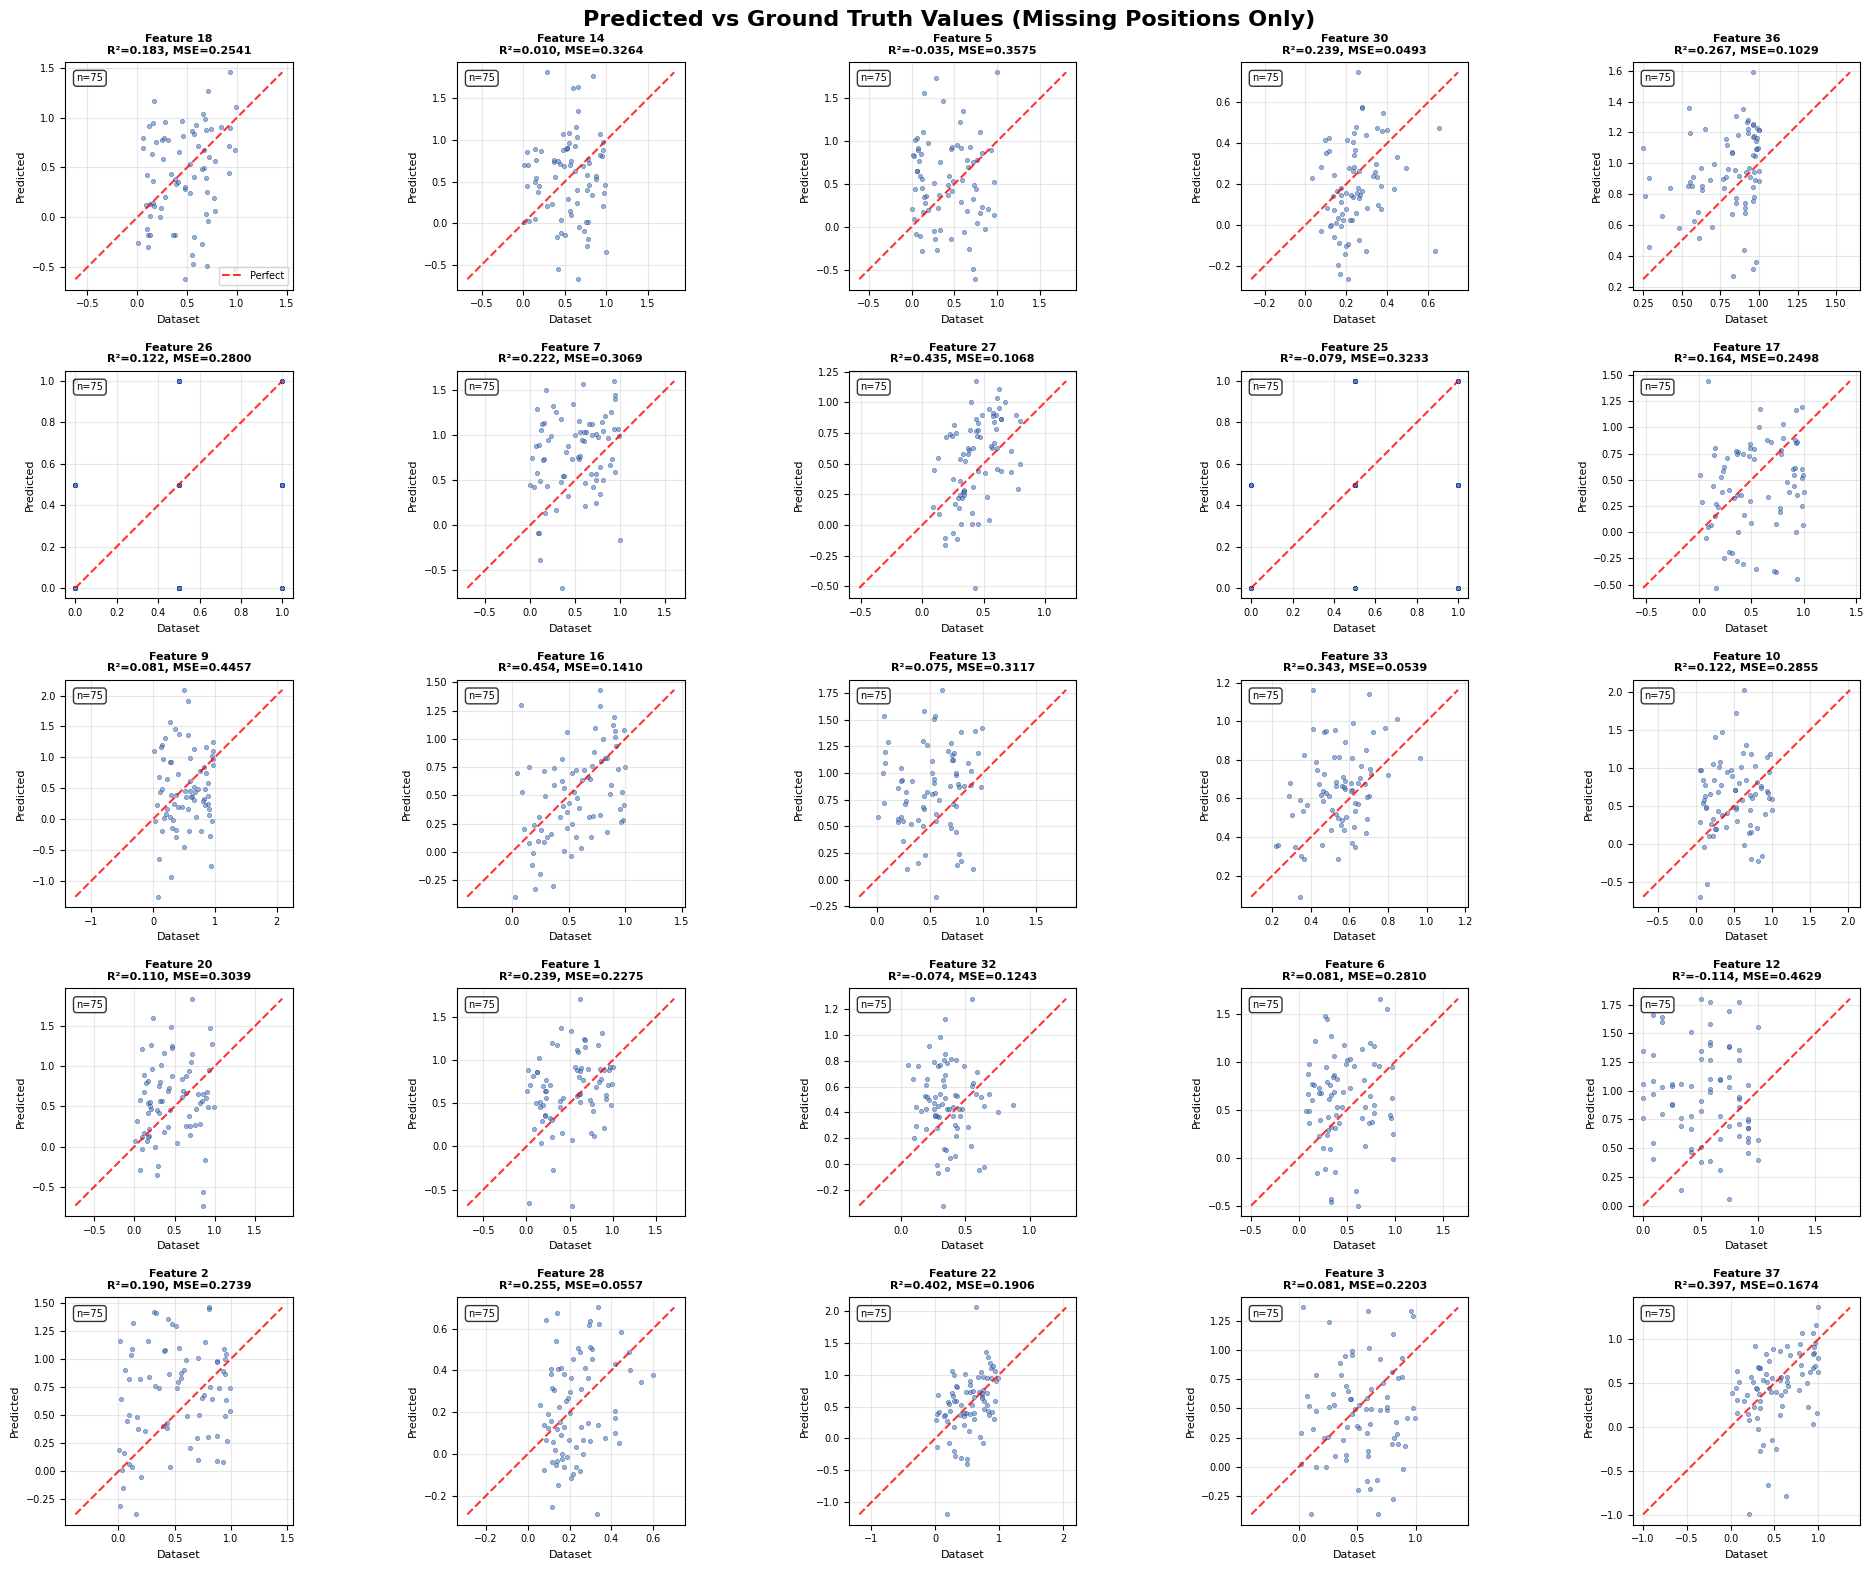

In [223]:
# Create the visualization
plot_prediction_scatter(test_imputations_denorm, test_original_denorm, test_masks, feature_names, n_features=37)



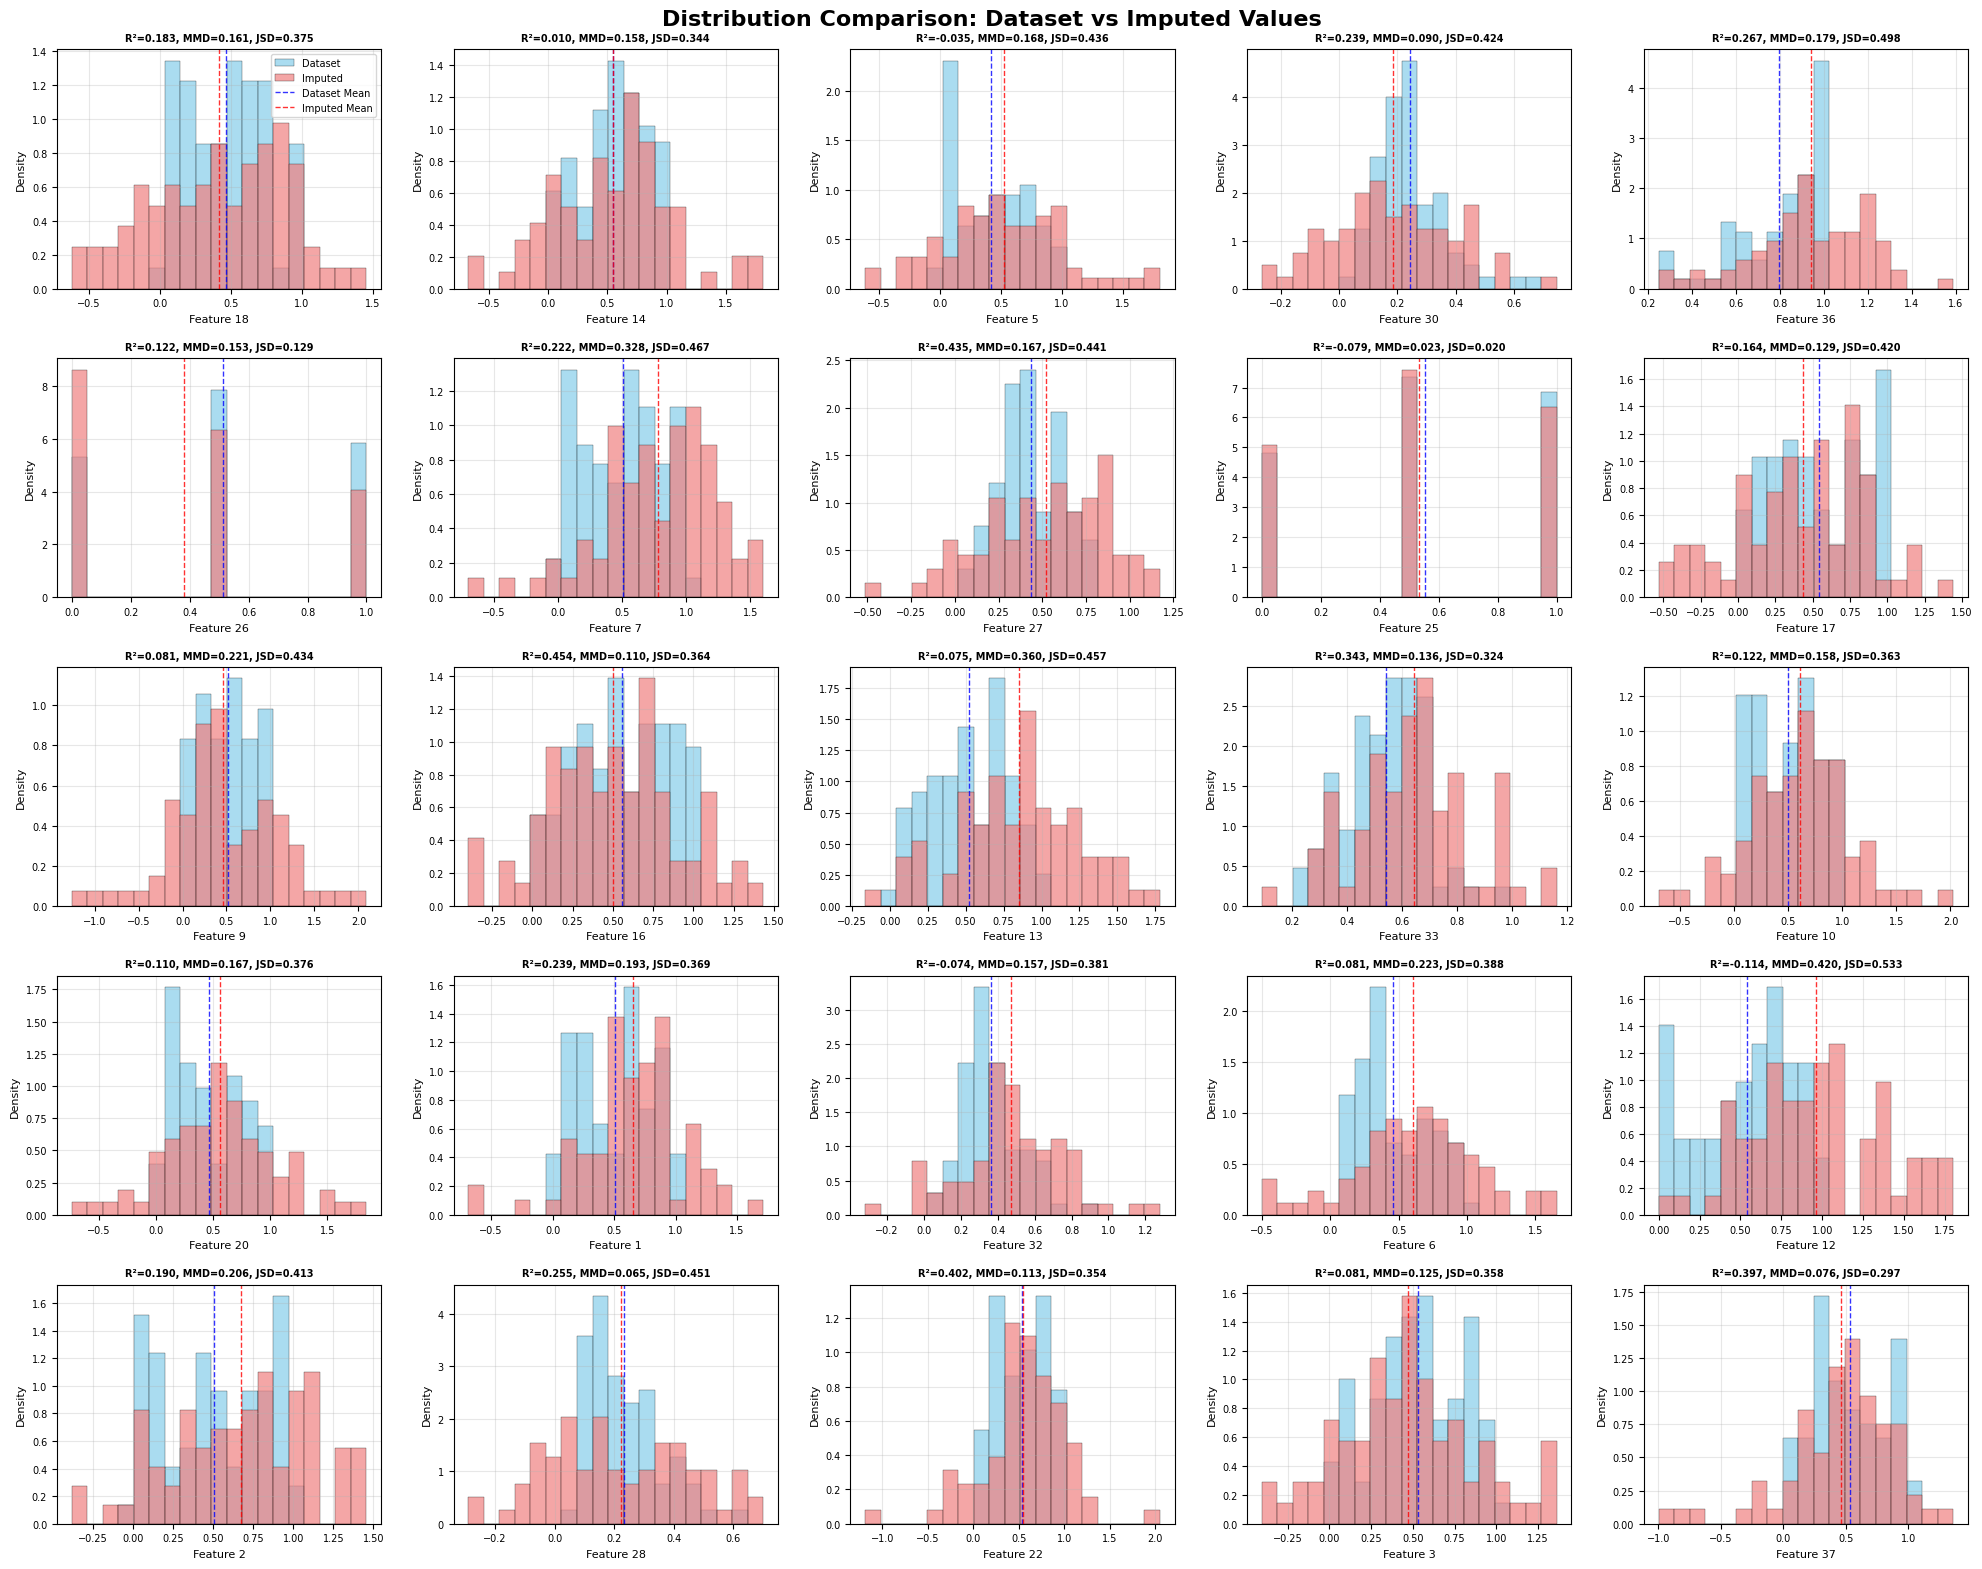

In [224]:
# Distribution comparison plots
plot_distribution_comparison(test_imputations_denorm, test_original_denorm,
                             test_masks, feature_names, n_features=25)


In [225]:
def generate_samples(model, X_test, test_loader, device, n_samples_per_test=100):
    """Generate multiple samples for a dataset using the trained model.
    """
    # We'll generate multiple samples
    test_samples = np.zeros((X_test.shape[0], n_samples_per_test, X_test.shape[1]))

    # Set model to evaluation mode
    model.eval()

    with torch.no_grad():
        # Create a progress bar for all samples
        from tqdm import tqdm

        for batch_idx, (batch_data, batch_mask) in enumerate(tqdm(test_loader, desc="Generating Samples")):
            batch_data = batch_data.to(device)
            batch_mask = batch_mask.to(device)

            # Calculate the indices for this batch
            start_idx = batch_idx * test_loader.batch_size
            end_idx = min(start_idx + test_loader.batch_size, X_test.shape[0])
            actual_batch_size = end_idx - start_idx

            # Generate multiple samples for each item in the batch
            for j in range(n_samples_per_test):
                # Get imputed sample using the model's sampling method
                imputed = model.sample(batch_data, batch_mask)

                # Store the samples (already in original scale since we didn't normalize)
                test_samples[start_idx:end_idx, j, :] = imputed.cpu().numpy()
    print(f"✓ Generated samples shape: {test_samples.shape}")
    print(f"  - {test_samples.shape[0]} samples")
    print(f"  - {test_samples.shape[1]} generated variations per sample")
    print(f"  - {test_samples.shape[2]} features per sample")

    # Data is already in original scale (no denormalization needed)
    test_samples_final = test_samples.copy()

    # Calculate summary statistics
    mean_across_samples = test_samples_final.mean(axis=1)  # Mean across the 100 samples

    print(f"  - Range of means: [{mean_across_samples.min():.4f}, {mean_across_samples.max():.4f}]")

    return test_samples

In [226]:
# Test Evaluation

print("="*70)
print("TEST EVALUATION")
print("="*70)

# Generate multiple samples for test using the trained model
print(f"Generating 100 samples for each of {X_test.shape[0]} test samples...")

test_samples = generate_samples(
    model, X_test, test_loader, device, n_samples_per_test=100
)

TEST EVALUATION
Generating 100 samples for each of 375 test samples...


Generating Samples: 100%|██████████| 6/6 [00:07<00:00,  1.33s/it]

✓ Generated samples shape: (375, 100, 37)
  - 375 samples
  - 100 generated variations per sample
  - 37 features per sample
  - Range of means: [-0.2967, 1.4950]


In [227]:
from evaluate import *
test_score = compute_score(generated_samples=test_samples, set_name='test')
print("Test score:", test_score)

Loading data...
✓ Found data in current directory
✓ Test data shape: (375, 37)
✓ Missing ratio: 20.0%
✓ Generated samples shape: (375, 100, 37)

📊 EVALUATION RESULTS
Missing values evaluated: 2,775
MSE          : 0.1114
MAE          : 0.2566
Correlation  : 0.309
JS Divergence: 0.0443

📈 FEATURE-WISE RESULTS
Feature  MSE        MAE        Corr     JSDiv    Count   
0        0.0972     0.2567     0.550    0.2024   75      
1        0.1491     0.3328     0.251    0.2943   75      
2        0.1578     0.3060     -0.085   0.1482   75      
3        0.1188     0.2858     0.118    0.2590   75      
4        0.1544     0.3154     -0.002   0.2137   75      
5        0.1432     0.3096     0.097    0.2768   75      
6        0.1970     0.3600     0.130    0.2146   75      
7        0.2574     0.4207     0.162    0.2935   75      
8        0.1424     0.3031     0.130    0.1865   75      
9        0.1659     0.3271     0.082    0.2074   75      
10       0.1367     0.3108     0.066    0.1948   75  

In [228]:
# Test2 Evaluation

print("="*70)
print("TEST2 EVALUATION")
print("="*70)

# Generate multiple samples for test2 using the trained model
print(f"Generating 100 samples for each of {X_test2.shape[0]} test2 samples...")

test2_samples = generate_samples(
    model, X_test2, test2_loader, device, n_samples_per_test=100
)

TEST2 EVALUATION
Generating 100 samples for each of 417 test2 samples...


Generating Samples: 100%|██████████| 7/7 [00:09<00:00,  1.36s/it]

✓ Generated samples shape: (417, 100, 37)
  - 417 samples
  - 100 generated variations per sample
  - 37 features per sample
  - Range of means: [-0.2869, 1.6461]


In [229]:
rng = np.random.default_rng()
id = rng.integers(1e8, 1e9-1)
np.save(f"{id}.npy", test2_samples)